# Part1

* Importing libraries

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string,nltk,re,pickle
from string import punctuation
nltk.download(['punkt','stopwords','wordnet'])
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
drive.mount('/content/drive/')
project_path = '/content/drive/My Drive/Data Science/NLP/Project1/'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Mounted at /content/drive/


# **Part 1: PROJECT OBJECTIVE**: The need is to build a NLP classifier which can use input text parameters to determine the label/s of the blog.


### 1. Import and analyse the data set.

In [2]:
df = pd.read_csv(project_path + "blogtext.csv")

In [ ]:
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [ ]:
df.info()
# There are 681284 rows of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


In [ ]:
df[df['id']==3581210]

,id,gender,age,topic,sign,date,text
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",I had an interesting conversation...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Somehow Coca-Cola has a way of su...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004","If anything, Korea is a country o..."
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Take a read of this news article ...
...,...,...,...,...,...,...,...
69,3581210,male,33,InvestmentBanking,Aquarius,"10,August,2004",Korea's pretty funny sometimes. ...
70,3581210,male,33,InvestmentBanking,Aquarius,"09,August,2004","Ya, I'm off to Canada/Vancouver a..."
71,3581210,male,33,InvestmentBanking,Aquarius,"09,August,2004","Ah, finally...someone else I know..."
72,3581210,male,33,InvestmentBanking,Aquarius,"08,August,2004",I think if I'm going to claim 여의도...


In [ ]:
df[df['id']==3581210]['text'].iloc[0]

"             Thanks to Yahoo!'s Toolbar I can now 'capture' the URLs of popups...which means now I can show you some cool links to Korean Pop (K-Pop) audio and video without the need to relate instructions like: 'go to the site, click on the pop-audio button then choose...'.  So, without further ado here is the link to 24-hour K-Pop  urlLink audio  and the  urlLink video  streaming.  Enjoy.         "

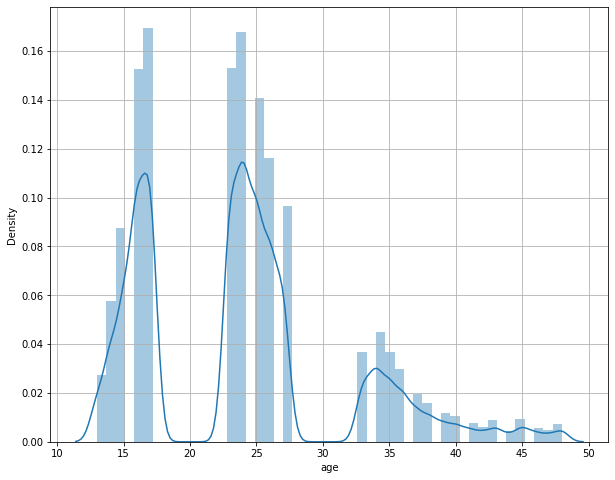

In [ ]:
plt.figure(figsize=(10,8))
plt.grid()
sns.distplot(df['age'])

#We notice a multimodal distribution, it has 3 peaks as mentioned in the project PDF.
# 8240 "10s" blogs (ages 13-17) - Peak1
# 8086 "20s" blogs(ages 23-27) - Peak2
# 2994 "30s" blogs (ages 33-47)- Peak3 - less number of people

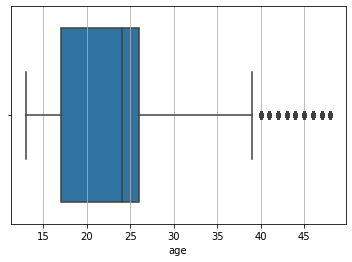

In [ ]:
#We notice 9 outliers 
plt.grid()
sns.boxplot(df['age'])

**Although it looks clear that the data is multimodal, lets prove it with the help of statistical evidence**

* Ha = The data is not normally distributed
* Ho = The data is normally distributed

**The p-value is less than alpha (P<0.5) considering we take the 95% confidence, so we reject the null hypothesis**

In [ ]:
from scipy.stats import shapiro
Stat,P_value = shapiro(df['age'])
print(P_value)

0.0


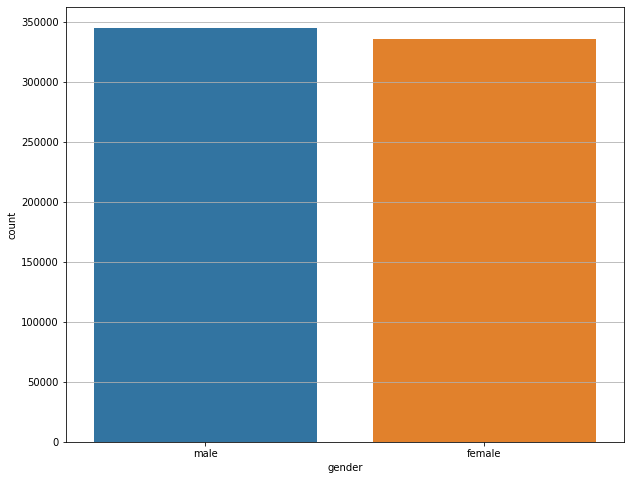

In [ ]:
plt.figure(figsize=(10,8))
plt.grid()
sns.countplot(x=df['gender'])
#Almost equal number of Male and Female

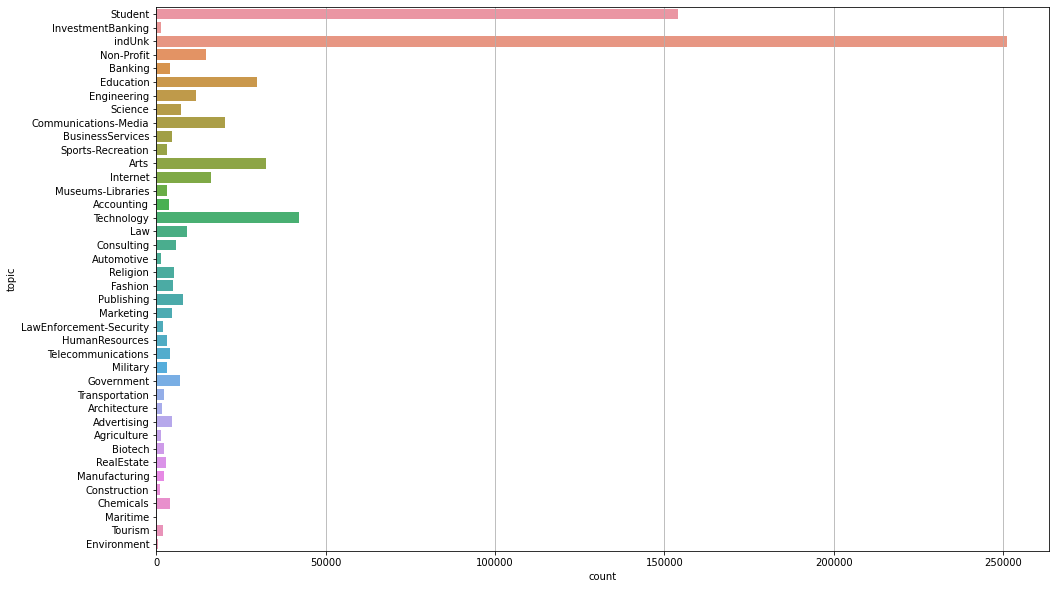

In [ ]:
plt.figure(figsize=(16,10))
plt.grid()
sns.countplot(y = df['topic'],orient="H")
#Here we notice a lot of mismatch (ie) imbalanced data, the student and indUnk contribute the most. This will lead to
#an imblance in dataset

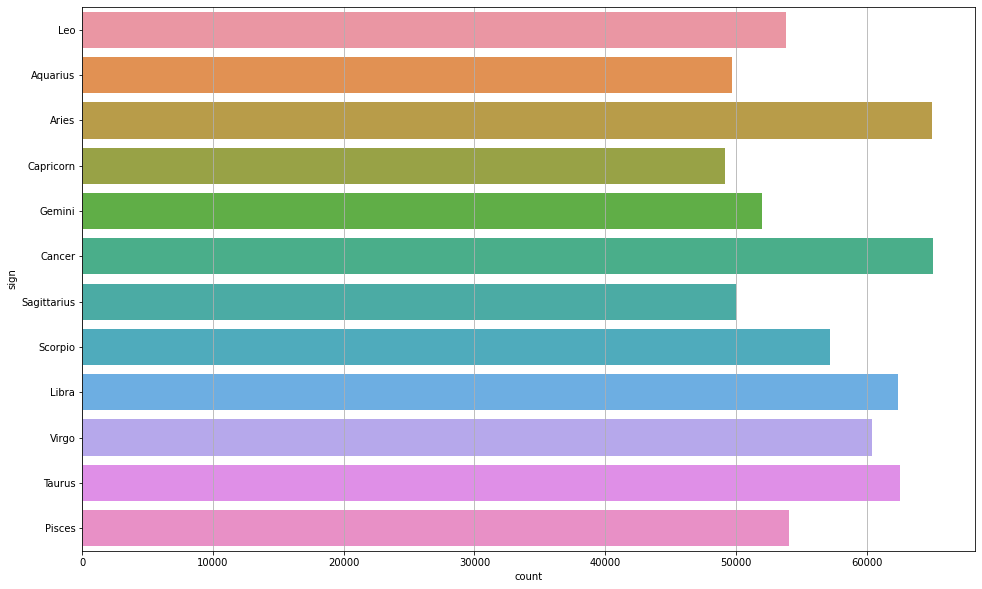

In [ ]:
plt.figure(figsize=(16,10))
plt.grid(axis="both")
sns.countplot(y = df['sign'])
#These classes are still imbalanced but compared to topic they look little better

# 2. Perform data pre-processing on the data:

*   **Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.<-**
*   Target/label merger and transformation
*   Train and test split
*   Vectorisation, etc.



#Operations performed:
### 1. Lowering the words
### 2. Remove html, 2 or more spaces, numbers, non-english words & punctuation symbols out
### 3. Remove stopwords and give a list of words

# **Raw form of coding**

In [ ]:
for t in df['text']:
  t = t.lower()
  t = re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",t)
  t = [i for i in t if i not in string.punctuation]
  t = "".join(t)
  b = []
  for i in nltk.word_tokenize(t):
    if i not in stopwords.words('english'):
      b.append(i)

# Simplified coding
# cleaned_text = [[i for i in nltk.word_tokenize("".join([i for i in re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",t.lower()) if i not in string.punctuation])) if i not in stopwords.words('english')] for t in df['text']]

# **Simplified coding** - Using List comprehension and eliminating multiple list, variable declaration, appending methods etc etc which might save some memory and time


In [3]:
cleaned_text = [[i for i in nltk.word_tokenize("".join([i for i in re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",t.lower()) if i not in string.punctuation])) if i not in stopwords.words('english')] for t in df['text']]


#Saving it in the form of array so that the above function is not run multiple times.
# np.save('/content/drive/My Drive/Data Science/NLP/Project1/cleaned_text.npy',np.array(cleaned_text))
# cleaned_text = np.load('/content/drive/My Drive/Data Science/NLP/Project1/cleaned_text.npy',allow_pickle=True)

In [ ]:
len(cleaned_text)

681284

In [ ]:
len(df['text'])

681284

*  **Target/label merger and transformation**  <--

  * In this case we see that there is Age, Gender, Topic and Zodiac sign which needs to be merged to create a target.
  * Once merged in the form of list, we will try to convert it into binary form of list that we usually use in neural networks with softmax
  * Now, this becomes 1 input vs multiple targets
  * In order to convert the target in the form of text to one hot bits we try to understand all the contents of target in the form of dictionary
  * Post this use that to convert target to binary encoded form

In [4]:
def target(x):
  return x['gender'],x['age'],x['topic'],x['sign']

df['age1'] = df['age'].apply(str)
df['Target_labels'] = df.apply(lambda col : [col['gender'],col['age1'],col['topic'],col['sign']], axis=1)

In [5]:
target_count=dict()

for tl in df['Target_labels'].values:
  for t in tl:
    if t in target_count:
      target_count[t]+=1
    else:
      target_count[t]=1

* **Train test split** <--

In [6]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_text, df['Target_labels'], test_size=0.3, random_state=11)

## **We use Multilabel binarizer as we have have Age, Gender, Topic and Sign to predict per each row of data**

In [7]:
binarizer=MultiLabelBinarizer(classes=sorted(target_count.keys()))
y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

* **Vectorisation** <--
  * Before vectorization we will try to stem or lemmatize the data so that we will get to know the models performance on both the data.(We dont try both Stemming and Lemmatization as the data is too huge to be run on any platform)
  * Post this we convert the text to vectors using both TF-IDF method and also Count vectorization(BOW).We stop only with stemming as Lemmatization takes more time.

  * I am personally not trying Word2Vec as it is crashing the Colab's memory and continues to run for more than 5 hrs in jupyter notebook and sometimes crashes with memory error message

In [15]:
  #Using Stemming & Lemmatization techinique
PS = PorterStemmer()
LM = WordNetLemmatizer()

#Vectorization done using both TF-IDF and BOW
tfidf = TfidfVectorizer()
cv = CountVectorizer()


In [ ]:
 X_train_s = []
for i in X_train:
  m = []
  for j in i:
    m.append(PS.stem(j))
  X_train_s.append(m)


X_test_s = []
for i in X_test:
  m = []
  for j in i:
    m.append(PS.stem(j))
  X_test_s.append(m)

In [ ]:
X_train_1 = [" ".join(i) for i in X_train_s]
X_test_1 = [" ".join(i) for i in X_test_s]
X_train_1 = tfidf.fit_transform(X_train_1)
X_test_1 = tfidf.transform(X_test_1)

# 3. Design, train, tune and test the best text classifier. 

## **Naive Bayes Theorem**
  * Currently stopping with Naive bayes theorem as the data is too big to be processed (6,81,284 rows of data)
  * Difficulty faced while Lowering the words, Removing html, more spaces, numbers, non-english words, stop words & punctuation symbols out. It took around 3+hours to complete this.
  * Post this the idea was to apply stemming or Lemmatization but even Stemming couldnt be done with ease due to RAM restrictions and high data hence i have stopped only with stem. It took around 2+ hours to complete this.
  * Instead of using Stemming or Lemmatization, i can explain what it does. For eg: if we have a total of 10000 words in vocabulary then applying a count vectorizer or TF-IDF might bring in a matrix with too many features, a matrix with 10000 rows and columns but if we apply stemming or lemmatization some of the words can be made into single word, for eg: Running, Runs, Ran and Run can be displayed as Run and similary for all the words which will reduce the complexity.
  * Running Naive Bayes theorem took around 40+ minutes and Similarly i can try out Logistic Regression, Support Vector Classifier,  Decision Tree Classifier etc but due to enormous data, i am stopping with Naive Bayes theorem. 
  * During this time my laptop crashed multiple times and Google colab also crashed multiple times so i had to store all the data in the form of numpy array to reload and process it for applying in a single ML model. The other way to solve this is by taking only 50,000 rows of data which can be pre-processed quickly and we can try applying multiple algorithms as well.

**Hint: The aim here Is to import the text, process it such a way that it can be taken as an inout to the ML/NN classifiers. Be analytical and experimental here in trying new
approaches to design the best model.**

* As the hint states the aim here is to import text, preprocess it so that it can fed to ML, post noticing this i focused only on applying a singl ML model.

In [ ]:
model= MultinomialNB(alpha=1.5)
model=OneVsRestClassifier(model)
model.fit(X_train_1,y_train)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.5, class_prior=None,
                                            fit_prior=True),
                    n_jobs=None)

In [ ]:
pred = model.predict(X_test_1)

In [ ]:
model.score(X_train_1,y_train)

0.001157480215895223

In [ ]:
model.score(X_test_1,y_test)

0.0016145919974949361

In [ ]:
print(classification_report(y_test,pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3983
           1       0.60      0.01      0.01      8324
           2       0.15      0.00      0.00     12504
           3       0.51      0.00      0.01     21776
           4       0.40      0.00      0.01     24282
           5       0.46      0.00      0.01     21811
           6       0.72      0.00      0.01     24115
           7       0.33      0.00      0.00     20038
           8       0.28      0.00      0.00     16665
           9       0.35      0.00      0.00     13817
          10       0.00      0.00      0.00      5220
          11       0.14      0.00      0.00      6216
          12       0.00      0.00      0.00      5305
          13       0.00      0.00      0.00      4269
          14       0.00      0.00      0.00      2750
          15       0.00      0.00      0.00      2285
          16       0.00      0.00      0.00      1701
          17       0.00    

### **4. Display and explain detail the classification report**

* As we can see above the model behaves very badly and gives a poor Accuracy metric. We dont touch even 10% of Accuracy probably because we have a wide variety of classes (80 classes) which is completely imbalanced, the data is too big to be processed and we have tried only one ML model without any hyperparameter tuning considering the hardware restrictions.

* The classes 77,78 & 79 constitute almost 30% of total data due to which we notice a better Precision, Recall and F1 score on those classes. The rest of the classes have a bad score and in this case we try to focus only on F1 Score since we want both the Precision and Recall to be high.

* Since we prefer overall data and not just any one class we look into micro average of F1 score which is 29%, i.e: aggregation of all classes to compute the 1 average metric.

* The data is completely imbalanced as we have around 80 classes, we need atleast equal classes but if we were to use the Upsampling, Downsampling, SMOTE or Class weights in RFC or DTC we need computational power and hence i am dropping it to single model.

# 5. Print the true vs predicted labels for any 5 entries from the dataset. <--
* Since we have used the MultiLabelBinarizer to convert multiple fields in 1 prediction, we can inverse transform the predicted values using same Multilabelbinarizer

* We try to pick the best 5 predicitons and display them for reference.

In [ ]:
prediction = binarizer.inverse_transform(pred)
Actual = binarizer.inverse_transform(y_test)

In [ ]:
for i,j in enumerate(prediction):
  if len(j) == 3 and i!= 1358 and i!= 1684 and i!= 2395:
    print(i)
    break
  else:
    pass

2983


* Prediction 1 - Perfecly aligned with the actual test data

In [ ]:
prediction[1581]

('16', 'Libra', 'female', 'indUnk')

In [ ]:
Actual[1581]

('16', 'Libra', 'female', 'indUnk')

* Prediction 2 - Missing the age

In [ ]:
prediction[1358]

('Cancer', 'female', 'indUnk')

In [ ]:
Actual[1358]

('40', 'Cancer', 'female', 'indUnk')

* Prediction 3 - Missing the age

In [ ]:
prediction[1684]

('Cancer', 'female', 'indUnk')

In [ ]:
Actual[1684]

('40', 'Cancer', 'female', 'indUnk')

* Prediction 4 - Missing the age

In [ ]:
prediction[2395]

('Taurus', 'female', 'indUnk')

In [ ]:
Actual[2395]

('14', 'Taurus', 'female', 'indUnk')

* Prediction 5 - Missing the age

In [ ]:
prediction[2983]

('Cancer', 'female', 'indUnk')

In [ ]:
Actual[2983]

('40', 'Cancer', 'female', 'indUnk')

## **For a change, lets take only 100000rows of data and try to build a model using that**

In [17]:
df1 = df[:100000]
#Picking only 100000 rows of data

cleaned_text1 = [[i for i in nltk.word_tokenize("".join([i for i in re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",t.lower()) if i not in string.punctuation])) if i not in stopwords.words('english')] for t in df1['text']]
#Cleaning the text from Stopwords, punctuations, nonenglish words, HTML tags, unnecessary spaces etc.

df1['age1'] = df1['age'].apply(str)
df1['Target_labels'] = df1.apply(lambda col : [col['gender'],col['age1'],col['topic'],col['sign']], axis=1)
#Creating Target labels


target_count1=dict()

for tl in df1['Target_labels'].values:
  for t in tl:
    if t in target_count1:
      target_count1[t]+=1
    else:
      target_count1[t]=1
#Collecting the target counts      

X_train, X_test, y_train, y_test = train_test_split(cleaned_text1, df1['Target_labels'], test_size=0.3, random_state=11)
#performing Train test split

binarizer=MultiLabelBinarizer(classes=sorted(target_count1.keys()))
y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)
#Converting the target to multilabel onehot encoded values

#Using Stemming & Lemmatization techinique
PS = PorterStemmer()
LM = WordNetLemmatizer()

#Vectorization done using both TF-IDF and BOW
tfidf = TfidfVectorizer()
cv = CountVectorizer()

In [ ]:
X_train_h = []
for i in X_train:
  m = []
  for j in i:
    m.append(PS.stem(j))
  X_train_h.append(m)


X_test_h = []
for i in X_test:
  m = []
  for j in i:
    m.append(PS.stem(j))
  X_test_h.append(m)

#Using Stem  

In [ ]:
X_train_L = []
for i in X_train:
  m = []
  for j in i:
    m.append(LM.lemmatize(j))
  X_train_L.append(m)


X_test_L = []
for i in X_test:
  m = []
  for j in i:
    m.append(LM.lemmatize(j))
  X_test_L.append(m)

#Using Lemmatization

In [ ]:
X_train_1 = [" ".join(i) for i in X_train_h]
X_test_1 = [" ".join(i) for i in X_test_h]

X_train_1 = tfidf.fit_transform(X_train_1)
X_test_1 = tfidf.transform(X_test_1)

#X_train & X_test prepared for Stemmed data

In [ ]:
X_train_2 = [" ".join(i) for i in X_train_L]
X_test_2 = [" ".join(i) for i in X_test_L]

X_train_2L = tfidf.fit_transform(X_train_2)
X_test_2L = tfidf.transform(X_test_2)

#X_train & X_test prepared for Lemmatized data

## 1. Using Decision Tree classifier using Stemmed data
 * This model gives a 21% of F1 score with the stemmed data

In [ ]:
model= DecisionTreeClassifier(max_depth=5)
model= OneVsRestClassifier(model)
model.fit(X_train_1,y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=5,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
                                          

In [ ]:
pred = model.predict(X_test_1)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.93      0.15      0.26       432
           1       0.83      0.04      0.08      1017
           2       0.95      0.05      0.10      1942
           3       0.96      0.11      0.20      2532
           4       0.70      0.07      0.12      3766
           5       0.86      0.05      0.09      3214
           6       0.97      0.06      0.12      3596
           7       0.94      0.05      0.09      2577
           8       0.90      0.11      0.19      2440
           9       0.98      0.05      0.10      2404
          10       0.93      0.06      0.11       834
          11       0.92      0.42      0.57       742
          12       0.96      0.15      0.26      1427
          13       0.86      0.26      0.40       943
          14       0.65      0.07      0.12       253
          15       0.97      0.28      0.43       259
          16       0.69      0.10      0.18       177
          17       0.64    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. Using Lemmatized data for Decision Tree Classifier
* This model gives a 21% of F1 score with the Lemmatized data

Both the Stemmed and Lemmatized data give the same F1score since we took very few data maybe if we take entire data Stemming might give us better prediction.

In [ ]:
model1= DecisionTreeClassifier(max_depth=5)
model2= OneVsRestClassifier(model1)
model2.fit(X_train_2L,y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=5,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
                                          

In [ ]:
pred1 = model2.predict(X_test_2L)

In [ ]:
print(classification_report(y_test,pred1))

              precision    recall  f1-score   support

           0       0.89      0.16      0.28       432
           1       0.77      0.04      0.08      1017
           2       0.96      0.05      0.10      1942
           3       0.97      0.11      0.20      2532
           4       0.72      0.07      0.13      3766
           5       0.96      0.05      0.09      3214
           6       0.90      0.07      0.13      3596
           7       0.96      0.05      0.09      2577
           8       0.96      0.09      0.16      2440
           9       0.78      0.06      0.11      2404
          10       0.94      0.06      0.10       834
          11       0.92      0.42      0.58       742
          12       0.91      0.16      0.27      1427
          13       0.87      0.27      0.41       943
          14       0.67      0.06      0.10       253
          15       0.89      0.29      0.44       259
          16       0.80      0.11      0.20       177
          17       0.64    

In [ ]:
pred1 = binarizer.inverse_transform(pred1)

In [ ]:
y_test = binarizer.inverse_transform(y_test)

In [ ]:
pred1[38]

('36', 'Aries', 'Fashion', 'male')

In [ ]:
y_test[38]

('36', 'Aries', 'Fashion', 'male')

In [ ]:
pred1[78]

('34', 'Sagittarius', 'female', 'indUnk')

In [ ]:
y_test[78]

('34', 'Sagittarius', 'female', 'indUnk')

# Part 2 - Great Learning Chatbot

In [ ]:
mm = pd.read_json('/content/drive/My Drive/Data Science/NLP/Project1/GL Bot.json')

* We first need to create a Dataframe using the Json input:
1. Normalize the Json input to generate a Dataframe (df1)

In [ ]:
df1 = pd.json_normalize(mm['intents'])
#We normalize the json to convert it into a Dataframe

In [ ]:
df1.head()

,tag,patterns,responses,context_set
0,Intro,"[hi, how are you, is anyone there, hello, what...",[Hello! how can i help you ?],
1,Exit,"[thank you, thanks, cya, see you, later, see y...","[I hope I was able to assist you, Good Bye]",
2,Olympus,"[olympus, explain me how olympus works, I am n...",[Link: Olympus wiki],
3,SL,"[i am not able to understand svm, explain me h...",[Link: Machine Learning wiki ],
4,NN,"[what is deep learning, unable to understand d...",[Link: Neural Nets wiki],


2. Iterate over the Json to generate a Dataframe (df2)

In [ ]:
df2 = pd.DataFrame()
for i in mm['intents']:
  for j in i['patterns']:
    df2 = df2.append({'Tag':i['tag'],'Responses':i['responses'][0],'Pattern':j},ignore_index=True)

In [ ]:
df2.head()

,Pattern,Responses,Tag
0,hi,Hello! how can i help you ?,Intro
1,how are you,Hello! how can i help you ?,Intro
2,is anyone there,Hello! how can i help you ?,Intro
3,hello,Hello! how can i help you ?,Intro
4,whats up,Hello! how can i help you ?,Intro


## We have 8 unique responses that the chat bot is limited to give as a response for any input. **The idea is to create a proper ML model that can take any input and share one of these responses as output and we have to make sure the response is relevant and not Irrelevant.**

* In this we notice a lot of stopwords used as an input and hence we will not work on eliminating the stopwords and also we have very few input

In [ ]:
le = LabelEncoder()
df2['Target'] = le.fit_transform(df2['Responses'])
df2['Target'].value_counts()

#We see there is a complete imbalance in the dataset, we need to find a way to balance them out.
#We will manually try to fillin the values to balance the dataset

3    29
4    24
0    20
2    16
5    13
7     9
6     9
1     8
Name: Target, dtype: int64

In [ ]:
#Manually pushing some inputs to balance the classes
df2 = df2.append([{'Pattern':"Ok, i am good","Responses":"I hope I was able to assist you, Good Bye","Tag":"Exit","Target":2 },
                  {'Pattern':"Alright, i'm good","Responses":"I hope I was able to assist you, Good Bye","Tag":"Exit","Target":2},
                  {'Pattern':"Thanks for help","Responses":"I hope I was able to assist you, Good Bye","Tag":"Exit","Target":2 },
                  {'Pattern':"Doubt cleared","Responses":"I hope I was able to assist you, Good Bye","Tag":"Exit","Target":2},
                  {'Pattern':"Exit","Responses":"I hope I was able to assist you, Good Bye","Tag":"Exit","Target":2},
                  {'Pattern':"quit cleared","Responses":"I hope I was able to assist you, Good Bye","Tag":"Exit","Target":2},
                  {'Pattern':"Portal not working","Responses":"Link: Olympus wiki","Tag":"Olympus","Target":5 },
                  {'Pattern':"Give me portal link","Responses":"Link: Olympus wiki","Tag":"Olympus","Target":5},
                  {'Pattern':"Olympus Portal","Responses":"Link: Olympus wiki","Tag":"Olympus","Target":5 },
                  {'Pattern':"PG portal","Responses":"Link: Olympus wiki","Tag":"Olympus","Target":5},
                  {'Pattern':"Course portal","Responses":"Link: Olympus wiki","Tag":"Olympus","Target":5},
                  {'Pattern':"Poc for olympus portal","Responses":"Link: Olympus wiki","Tag":"Olympus","Target":5},
                  {'Pattern':"Help me on olympus portal","Responses":"Link: Olympus wiki","Tag":"Olympus","Target":5},
                  {'Pattern':"I dont see a solution","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"Where is the solution","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"connect me to a human","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"Want to talk to a person","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"This is not an answer","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"Its not a solution","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"This is not a solution","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"Please push it to a human","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"I do not want to talk to a bot","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"Do not connect to a bot","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"Someone please answer my question","Responses":"Tarnsferring the request to your PM","Tag":"Ticket","Target":7 },
                  {'Pattern':"Get lost","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"You stupid","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"Useless bot","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"Get lost","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"Dont talk like an idiot","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"Do you have sense","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"Senseless creature","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"Shut your mouth","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"Dont speak like a dummy","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"You stupid dummy","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"Shut up","Responses":"Please use respectful words","Tag":"Profane","Target":6 },
                  {'Pattern':"Do i know you","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"Is anyone there","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"Who is there","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"Who is you","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"Your name please","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"name please","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"Speak up","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"Are you a human","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"Do you answer questions","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"Who is learning assistant","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"who is supporting assistant","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 },
                  {'Pattern':"Any assistant","Responses":"I am your virtual learning assistant","Tag":"Bot","Target":1 }],ignore_index=True)

In [ ]:
df2['Target'].value_counts()

3    29
4    24
2    22
7    20
6    20
5    20
1    20
0    20
Name: Target, dtype: int64

In [ ]:
df2['Responses'].nunique()

8

## Data Cleaning

In [ ]:
cleaned_text1 = [[i for i in nltk.word_tokenize("".join([i for i in re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",t.lower()) if i not in string.punctuation]))] for t in df2['Pattern']]

In [ ]:
PS = PorterStemmer()
WNL = WordNetLemmatizer()
X_train, X_test, y_train, y_test = train_test_split(cleaned_text1, df2['Target'], test_size=0.3, random_state=11)

X_train_L = []
for i in X_train:
  m = []
  for j in i:
    m.append(WNL.lemmatize(j,pos='v'))
  X_train_L.append(m)


X_test_L = []
for i in X_test:
  m = []
  for j in i:
    m.append(WNL.lemmatize(j,pos='v'))
  X_test_L.append(m)

#Using Lemmatization

X_train_S = []
for i in X_train:
  m = []
  for j in i:
    m.append(PS.stem(j))
  X_train_S.append(m)


X_test_S = []
for i in X_test:
  m = []
  for j in i:
    m.append(PS.stem(j))
  X_test_S.append(m)

#Using Stemmer

X_train_S = [" ".join(i) for i in X_train_S]
X_test_S = [" ".join(i) for i in X_test_S]
tfs = TfidfVectorizer()
X_train_S_tf = tfs.fit_transform(X_train_S)
X_test_S_tf = tfs.transform(X_test_S)

X_train_L = [" ".join(i) for i in X_train_L]
X_test_L = [" ".join(i) for i in X_test_L]
tfL = TfidfVectorizer()
X_train_L_tf = tfL.fit_transform(X_train_L)
X_test_L_tf = tfL.transform(X_test_L)

1. Naive Bayes theorem using Lemmatization

In [ ]:
model_nb = MultinomialNB()
model_nb.fit(X_train_L_tf,y_train)
pred_L_tf = model_nb.predict(X_test_L_tf)

#using LEmma data

In [ ]:
model_nb.predict(X_test_L_tf[0])

array([3])

In [ ]:
X_test_L_tf[0].shape

(1, 157)

In [ ]:
print(classification_report(y_test,pred_L_tf))

              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.83      0.71      0.77         7
           2       0.60      0.60      0.60         5
           3       0.41      1.00      0.58         9
           4       1.00      0.38      0.55         8
           5       1.00      1.00      1.00         8
           6       0.67      0.50      0.57         4
           7       0.75      0.60      0.67         5

    accuracy                           0.66        53
   macro avg       0.78      0.63      0.65        53
weighted avg       0.79      0.66      0.65        53



2. Naive Bayes theorem using Stemmed data

In [ ]:
model_nb_S = MultinomialNB(alpha=0.5)
model_nb_S.fit(X_train_S_tf,y_train)
pred_S_tf = model_nb_S.predict(X_test_S_tf)

#using Stem data - Better accuracy

In [ ]:
print(classification_report(y_test,pred_S_tf))

              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.75      0.86      0.80         7
           2       0.60      0.60      0.60         5
           3       0.47      1.00      0.64         9
           4       1.00      0.50      0.67         8
           5       1.00      1.00      1.00         8
           6       0.67      0.50      0.57         4
           7       0.75      0.60      0.67         5

    accuracy                           0.70        53
   macro avg       0.78      0.67      0.67        53
weighted avg       0.79      0.70      0.69        53



In [ ]:
pk_du = pickle.dump(model_nb_S,open('/content/drive/My Drive/Data Science/NLP/Project1/model_nb_S.pkl','wb'))

3. Decision Tree Classifier using Lemmatized data

In [ ]:
DTC = DecisionTreeClassifier(max_depth=5)
DTC.fit(X_train_L_tf,y_train)
pred_L_tf_DTC = model_nb.predict(X_test_L_tf)

In [ ]:
print(classification_report(y_test,pred_L_tf_DTC))

              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.83      0.71      0.77         7
           2       0.60      0.60      0.60         5
           3       0.41      1.00      0.58         9
           4       1.00      0.38      0.55         8
           5       1.00      1.00      1.00         8
           6       0.67      0.50      0.57         4
           7       0.75      0.60      0.67         5

    accuracy                           0.66        53
   macro avg       0.78      0.63      0.65        53
weighted avg       0.79      0.66      0.65        53



4. Decision Tree Classifier using stemmed data

In [ ]:
DTC_s = DecisionTreeClassifier(max_depth=5)
DTC_s.fit(X_train_S_tf,y_train)
pred_s_tf_DTC = DTC_s.predict(X_test_S_tf)

In [ ]:
print(classification_report(y_test,pred_s_tf_DTC))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       1.00      0.14      0.25         7
           2       1.00      0.20      0.33         5
           3       1.00      0.44      0.62         9
           4       0.20      1.00      0.33         8
           5       1.00      0.62      0.77         8
           6       0.00      0.00      0.00         4
           7       0.50      0.20      0.29         5

    accuracy                           0.38        53
   macro avg       0.59      0.33      0.32        53
weighted avg       0.62      0.38      0.36        53



5. Random Forest Classifier

In [ ]:
RFC = RandomForestClassifier()
param_grid = {"n_estimators":[50,100,150,200,250,300,350,400,450,500],"criterion":['gini','entropy']}

# , , , min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
# max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, 
# n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None


GSCV = GridSearchCV(estimator=RFC,param_grid=param_grid)
GSCV.fit(X_train_L_tf,y_train)
pred_L_tf_RFC = GSCV.predict(X_test_L_tf)

In [ ]:
print(classification_report(y_test,pred_L_tf_RFC))

              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.80      0.57      0.67         7
           2       0.75      0.60      0.67         5
           3       0.45      1.00      0.62         9
           4       1.00      0.38      0.55         8
           5       1.00      1.00      1.00         8
           6       1.00      0.50      0.67         4
           7       1.00      0.60      0.75         5

    accuracy                           0.68        53
   macro avg       0.81      0.65      0.68        53
weighted avg       0.79      0.68      0.68        53



In [ ]:
X_train_L_tf1.shape

(122, 157)

In [ ]:
X_train_S_tf1.shape

(122, 158)

6. Lets use Neural Networks

In [ ]:
X_train_L_tf1 = X_train_L_tf.toarray()
X_test_L_tf1 = X_test_L_tf.toarray()
X_train_S_tf1 = X_train_S_tf.toarray()
X_test_S_tf1 = X_test_S_tf.toarray()

In [ ]:
y_train_tc = to_categorical(y_train,num_classes=8)
y_test_tc = to_categorical(y_test,num_classes=8)

In [ ]:
NN_s = Sequential()
NN_s.add(Dense(200,input_shape=(158,),activation='relu'))
NN_s.add(Dense(150,activation='relu'))
NN_s.add(Dense(100,activation='relu'))
NN_s.add(Dense(50,activation='relu'))
NN_s.add(Dense(25,activation='relu'))
NN_s.add(Dense(8,activation='softmax'))

NN_L = Sequential()
NN_L.add(Dense(200,input_shape=(157,),activation='relu'))
NN_L.add(Dense(150,activation='relu'))
NN_L.add(Dense(100,activation='relu'))
NN_L.add(Dense(50,activation='relu'))
NN_L.add(Dense(25,activation='relu'))
NN_L.add(Dense(8,activation='softmax'))

* Neural Network with Lemmatized data - Adam Optimizer

In [ ]:
NN_L1 = Sequential()
NN_L1.add(Dense(200,input_shape=(157,),activation='relu'))
NN_L1.add(Dense(150,activation='relu'))
NN_L1.add(Dense(100,activation='relu'))
NN_L1.add(Dense(50,activation='relu'))
NN_L1.add(Dense(25,activation='relu'))
NN_L1.add(Dense(8,activation='softmax'))
NN_L1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
NN_L1.fit(X_train_L_tf1,y_train_tc,epochs=100,validation_data=(X_test_L_tf1,y_test_tc))

Epoch 1/100
4/4 [==============================] - 1s 72ms/step - loss: 2.0765 - accuracy: 0.1311 - val_loss: 2.0749 - val_accuracy: 0.1509
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 2.0525 - accuracy: 0.1803 - val_loss: 2.0654 - val_accuracy: 0.1698
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 2.0262 - accuracy: 0.2049 - val_loss: 2.0511 - val_accuracy: 0.1698
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 1.9916 - accuracy: 0.2951 - val_loss: 2.0307 - val_accuracy: 0.1698
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 1.9435 - accuracy: 0.3361 - val_loss: 2.0037 - val_accuracy: 0.1887
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 1.8791 - accuracy: 0.3689 - val_loss: 1.9663 - val_accuracy: 0.2075
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 1.7969 - accuracy: 0.4016 - val_loss: 1.9180 - val_accuracy: 0.2642
Epoch 8/100
4/4 [===

* Neural Network with Lemmatized data - SGD Optimizer

In [ ]:
NN_L2 = Sequential()
NN_L2.add(Dense(200,input_shape=(157,),activation='relu'))
NN_L2.add(Dense(150,activation='relu'))
NN_L2.add(Dense(100,activation='relu'))
NN_L2.add(Dense(50,activation='relu'))
NN_L2.add(Dense(25,activation='relu'))
NN_L2.add(Dense(8,activation='softmax'))
NN_L2.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
NN_L2.fit(X_train_L_tf1,y_train_tc,epochs=110,validation_data=(X_test_L_tf1,y_test_tc))

Epoch 1/110
4/4 [==============================] - 1s 85ms/step - loss: 2.0795 - accuracy: 0.1230 - val_loss: 2.0756 - val_accuracy: 0.1698
Epoch 2/110
4/4 [==============================] - 0s 13ms/step - loss: 2.0787 - accuracy: 0.1475 - val_loss: 2.0755 - val_accuracy: 0.1698
Epoch 3/110
4/4 [==============================] - 0s 12ms/step - loss: 2.0780 - accuracy: 0.1557 - val_loss: 2.0755 - val_accuracy: 0.2264
Epoch 4/110
4/4 [==============================] - 0s 12ms/step - loss: 2.0773 - accuracy: 0.1967 - val_loss: 2.0754 - val_accuracy: 0.2264
Epoch 5/110
4/4 [==============================] - 0s 12ms/step - loss: 2.0767 - accuracy: 0.2049 - val_loss: 2.0753 - val_accuracy: 0.2453
Epoch 6/110
4/4 [==============================] - 0s 12ms/step - loss: 2.0762 - accuracy: 0.2295 - val_loss: 2.0752 - val_accuracy: 0.2642
Epoch 7/110
4/4 [==============================] - 0s 12ms/step - loss: 2.0756 - accuracy: 0.2459 - val_loss: 2.0750 - val_accuracy: 0.2453
Epoch 8/110
4/4 [===

* Neural Network with Lemmatized data - RMS prop optimizer

In [ ]:
NN_L3 = Sequential()
NN_L3.add(Dense(200,input_shape=(157,),activation='relu'))
NN_L3.add(Dense(150,activation='relu'))
NN_L3.add(Dense(100,activation='relu'))
NN_L3.add(Dense(50,activation='relu'))
NN_L3.add(Dense(25,activation='relu'))
NN_L3.add(Dense(8,activation='softmax'))
NN_L3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
NN_L3.fit(X_train_L_tf1,y_train_tc,epochs=110,validation_data=(X_test_L_tf1,y_test_tc))

Epoch 1/110
4/4 [==============================] - 1s 76ms/step - loss: 2.0785 - accuracy: 0.1803 - val_loss: 2.0679 - val_accuracy: 0.1887
Epoch 2/110
4/4 [==============================] - 0s 14ms/step - loss: 2.0432 - accuracy: 0.3033 - val_loss: 2.0513 - val_accuracy: 0.1509
Epoch 3/110
4/4 [==============================] - 0s 13ms/step - loss: 1.9838 - accuracy: 0.3770 - val_loss: 2.0003 - val_accuracy: 0.1887
Epoch 4/110
4/4 [==============================] - 0s 13ms/step - loss: 1.8845 - accuracy: 0.4590 - val_loss: 1.9303 - val_accuracy: 0.2830
Epoch 5/110
4/4 [==============================] - 0s 13ms/step - loss: 1.7520 - accuracy: 0.5656 - val_loss: 1.8335 - val_accuracy: 0.4528
Epoch 6/110
4/4 [==============================] - 0s 14ms/step - loss: 1.6287 - accuracy: 0.5410 - val_loss: 1.7647 - val_accuracy: 0.3962
Epoch 7/110
4/4 [==============================] - 0s 16ms/step - loss: 1.4289 - accuracy: 0.6967 - val_loss: 1.6714 - val_accuracy: 0.4340
Epoch 8/110
4/4 [===

* We ran Neural Network for the Lemmatized data with Adam, RMSprop and SGD optimizers without any hyperparameter tuning for 100 epochs, we notice that **RMSprop** with better accuracy on validation, we will focus on tweaking this optimizer and tune hyperparameters to get better model

In [ ]:
NN_L3 = Sequential()
NN_L3.add(Dense(200,input_shape=(157,),activation='relu'))
NN_L3.add(Dropout(0.2))
NN_L3.add(Dense(150,activation='relu'))
NN_L3.add(Dropout(0.2))
NN_L3.add(Dense(100,activation='relu'))
NN_L3.add(Dropout(0.2))
NN_L3.add(Dense(50,activation='relu'))
NN_L3.add(Dropout(0.2))
NN_L3.add(Dense(25,activation='relu'))
NN_L3.add(Dense(8,activation='softmax'))
rms = RMSprop(learning_rate=0.001, rho=0.2, momentum=0.8, epsilon=1e-04)
ES=EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10)
NN_L3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
NN_L3.fit(X_train_L_tf1,y_train_tc,epochs=500,validation_data=(X_test_L_tf1,y_test_tc))

Epoch 1/500
4/4 [==============================] - 1s 76ms/step - loss: 2.0768 - accuracy: 0.1557 - val_loss: 2.0718 - val_accuracy: 0.2075
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 2.0636 - accuracy: 0.2213 - val_loss: 2.0569 - val_accuracy: 0.3585
Epoch 3/500
4/4 [==============================] - 0s 12ms/step - loss: 2.0518 - accuracy: 0.2705 - val_loss: 2.0468 - val_accuracy: 0.3396
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 2.0354 - accuracy: 0.2787 - val_loss: 2.0343 - val_accuracy: 0.3019
Epoch 5/500
4/4 [==============================] - 0s 15ms/step - loss: 1.9995 - accuracy: 0.3934 - val_loss: 2.0107 - val_accuracy: 0.3396
Epoch 6/500
4/4 [==============================] - 0s 12ms/step - loss: 1.9649 - accuracy: 0.3689 - val_loss: 1.9789 - val_accuracy: 0.3774
Epoch 7/500
4/4 [==============================] - 0s 13ms/step - loss: 1.9195 - accuracy: 0.4426 - val_loss: 1.9405 - val_accuracy: 0.3208
Epoch 8/500
4/4 [===

* Neural Network for Stemmed data with adam optimizer

In [ ]:
NN_s1 = Sequential()
NN_s1.add(Dense(200,input_shape=(158,),activation='relu'))
NN_s1.add(Dense(150,activation='relu'))
NN_s1.add(Dense(100,activation='relu'))
NN_s1.add(Dense(50,activation='relu'))
NN_s1.add(Dense(25,activation='relu'))
NN_s1.add(Dense(8,activation='softmax'))
NN_s1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
NN_s1.fit(X_train_S_tf1,y_train_tc,epochs=100,validation_data=(X_test_S_tf1,y_test_tc))

Epoch 1/100
4/4 [==============================] - 1s 73ms/step - loss: 2.0809 - accuracy: 0.0984 - val_loss: 2.0728 - val_accuracy: 0.1887
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 2.0588 - accuracy: 0.2951 - val_loss: 2.0665 - val_accuracy: 0.1321
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 2.0382 - accuracy: 0.3361 - val_loss: 2.0538 - val_accuracy: 0.1321
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 2.0071 - accuracy: 0.3525 - val_loss: 2.0371 - val_accuracy: 0.1887
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 1.9694 - accuracy: 0.3852 - val_loss: 2.0122 - val_accuracy: 0.2264
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 1.9079 - accuracy: 0.4590 - val_loss: 1.9755 - val_accuracy: 0.2264
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 1.8289 - accuracy: 0.4426 - val_loss: 1.9278 - val_accuracy: 0.2453
Epoch 8/100
4/4 [===

* Neural Network with Stemmed data using SGD optimizer

In [ ]:
NN_s2 = Sequential()
NN_s2.add(Dense(200,input_shape=(158,),activation='relu'))
NN_s2.add(Dense(150,activation='relu'))
NN_s2.add(Dense(100,activation='relu'))
NN_s2.add(Dense(50,activation='relu'))
NN_s2.add(Dense(25,activation='relu'))
NN_s2.add(Dense(8,activation='softmax'))
NN_s2.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
NN_s2.fit(X_train_S_tf1,y_train_tc,epochs=100,validation_data=(X_test_S_tf1,y_test_tc))

Epoch 1/100
4/4 [==============================] - 1s 71ms/step - loss: 2.0818 - accuracy: 0.1066 - val_loss: 2.0814 - val_accuracy: 0.1132
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 2.0813 - accuracy: 0.1066 - val_loss: 2.0812 - val_accuracy: 0.1132
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 2.0805 - accuracy: 0.1066 - val_loss: 2.0809 - val_accuracy: 0.1509
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 2.0799 - accuracy: 0.1230 - val_loss: 2.0807 - val_accuracy: 0.1698
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 2.0792 - accuracy: 0.1311 - val_loss: 2.0804 - val_accuracy: 0.1698
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 2.0787 - accuracy: 0.1311 - val_loss: 2.0802 - val_accuracy: 0.1698
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 2.0780 - accuracy: 0.1721 - val_loss: 2.0800 - val_accuracy: 0.1132
Epoch 8/100
4/4 [===

* Neural Network with Stemmed data and RMS prop optimizer

In [ ]:
NN_s3 = Sequential()
NN_s3.add(Dense(200,input_shape=(158,),activation='relu'))
NN_s3.add(Dense(150,activation='relu'))
NN_s3.add(Dense(100,activation='relu'))
NN_s3.add(Dense(50,activation='relu'))
NN_s3.add(Dense(25,activation='relu'))
NN_s3.add(Dense(8,activation='softmax'))
NN_s3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
NN_s3.fit(X_train_S_tf1,y_train_tc,epochs=100,validation_data=(X_test_S_tf1,y_test_tc))

Epoch 1/100
4/4 [==============================] - 1s 76ms/step - loss: 2.0757 - accuracy: 0.1311 - val_loss: 2.0618 - val_accuracy: 0.2642
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 2.0238 - accuracy: 0.3361 - val_loss: 2.0404 - val_accuracy: 0.1698
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 1.9493 - accuracy: 0.2869 - val_loss: 2.0046 - val_accuracy: 0.1698
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 1.8499 - accuracy: 0.3361 - val_loss: 1.9234 - val_accuracy: 0.3208
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 1.7124 - accuracy: 0.4836 - val_loss: 1.8528 - val_accuracy: 0.2830
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 1.5431 - accuracy: 0.5328 - val_loss: 1.7429 - val_accuracy: 0.4528
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 1.3771 - accuracy: 0.6230 - val_loss: 1.7553 - val_accuracy: 0.2830
Epoch 8/100
4/4 [===

* Neural network with stemmed data give same accuracy for RMSprop and Adam but we will choose only Adam as it is considered the best

## **Testing the simple chatbot**

In [ ]:
with open('/content/drive/My Drive/Data Science/NLP/Project1/model_nb_S.pkl', 'rb') as file:
  model = pickle.load(file)

def preprocess(x):
  x = "".join([i for i in re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",x.lower()) if i not in string.punctuation])
  x = tf.transform([PS.stem(i) for i in x.split(" ")])
  x = model.predict(x[0])
  x = le.inverse_transform([x])
  print(x)  

In [ ]:
def preprocess(x):
  x = "".join([i for i in re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",x.lower()) if i not in string.punctuation])
  x = tfs.transform([PS.stem(i) for i in x.split(" ")])
  x = model.predict(x[0])
  x = le.inverse_transform([x])
  print(x)

In [ ]:
preprocess("Hello ")

['Link: Machine Learning wiki ']


* Even though the chatbot's accuracy is good still we see that the classes it predicts is completely imbalanced, F1 score is not good for all the classes.

* This leads to not having a certain response pop up eventhough your question is directly related to that.

* We further clean up the data and make them little better to handle all the requests


In [53]:
df3 = pd.read_csv("/content/drive/My Drive/Data Science/NLP/Project1/Bot data.csv",encoding = "ISO-8859-1")

#Updated sheet with new comments

In [54]:
le = LabelEncoder()
df3['Target'] = le.fit_transform(df3['Responses'])
df3['Target'].value_counts()

#This is slightly balanced dataset with better inputs

4    41
3    40
7    37
2    36
5    35
6    33
0    33
1    31
Name: Target, dtype: int64

In [113]:
# pd.DataFrame(df3.groupby('Responses')['Target'].mean())
data_dict = {0:'Hello! how can i help you ?',1:'I am your virtual learning assistant',2:'I hope I was able to assist you, Good Bye',
             3:'Link: Machine Learning wiki',4:'Link: Neural Nets wiki',5:'Link: Olympus wiki',6:'Please use respectful words',
             7:'Transferring the request to your PM'}

def data_dict():
  return {0:'Hello! how can i help you ?',1:'I am your virtual learning assistant',2:'I hope I was able to assist you, Good Bye',
             3:'Link: Machine Learning wiki',4:'Link: Neural Nets wiki',5:'Link: Olympus wiki',6:'Please use respectful words',
             7:'Transferring the request to your PM'}



#Collecting data in the form of dictionary to inverse transform in the end             

In [20]:
cleaned_text1 = [[i for i in nltk.word_tokenize("".join([i for i in re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",t.lower()) if i not in string.punctuation]))] for t in df3['Pattern']]
# cleaned_text1 = [[i for i in nltk.word_tokenize("".join([i for i in re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",t.lower()) if i not in string.punctuation])) if i not in stopwords.words('english')] for t in df3['Pattern']]

In [21]:
PS = PorterStemmer()
WNL = WordNetLemmatizer()
X_train, X_test, y_train, y_test = train_test_split(cleaned_text1, df3['Target'], test_size=0.3, random_state=11)

X_train_L = []
for i in X_train:
  m = []
  for j in i:
    m.append(WNL.lemmatize(j,pos='v'))
  X_train_L.append(m)


X_test_L = []
for i in X_test:
  m = []
  for j in i:
    m.append(WNL.lemmatize(j,pos='v'))
  X_test_L.append(m)

#Using Lemmatization

X_train_S = []
for i in X_train:
  m = []
  for j in i:
    m.append(PS.stem(j))
  X_train_S.append(m)


X_test_S = []
for i in X_test:
  m = []
  for j in i:
    m.append(PS.stem(j))
  X_test_S.append(m)

#Using Stemmer

X_train_S = [" ".join(i) for i in X_train_S]
X_test_S = [" ".join(i) for i in X_test_S]


tfs = TfidfVectorizer()
X_train_S_tf = tfs.fit_transform(X_train_S)
X_test_S_tf = tfs.transform(X_test_S)


X_train_L = [" ".join(i) for i in X_train_L]
X_test_L = [" ".join(i) for i in X_test_L]
tfL = TfidfVectorizer()
X_train_L_tf = tfL.fit_transform(X_train_L)
X_test_L_tf = tfL.transform(X_test_L)

# We use Pipe operator as this is the best model with 71% accuracy

In [ ]:
model_nb = MultinomialNB(alpha=0.2)
pipe = Pipeline([("Lemmatizingvectorizer",tfL),
                 ("Model",model_nb)])
#using LEmma data

In [ ]:
pipe.fit(X_train_L,y_train)

Pipeline(memory=None,
         steps=[('Lemmatizingvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('Model',
                 MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
pred_L_tf = pipe.predict(X_test_L)

In [ ]:
print(classification_report(y_test,pred_L_tf))

#Even though the accuracy is bad, we can see that the F1 score is almost balanced on all classes

              precision    recall  f1-score   support

           0       0.83      0.36      0.50        14
           1       1.00      0.91      0.95        11
           2       1.00      0.60      0.75        10
           3       0.44      1.00      0.61        11
           4       1.00      0.64      0.78        14
           5       0.77      1.00      0.87        10
           6       0.67      0.40      0.50         5
           7       0.57      0.73      0.64        11

    accuracy                           0.71        86
   macro avg       0.79      0.70      0.70        86
weighted avg       0.80      0.71      0.71        86



In [52]:
model_nb_S = MultinomialNB(alpha=0.5)
model_nb_S.fit(X_train_S_tf,y_train)
pred_S_tf = model_nb_S.predict(X_test_S_tf)

#using Stem data - Better accuracy

In [ ]:
print(classification_report(y_test,pred_S_tf))

              precision    recall  f1-score   support

           0       1.00      0.36      0.53        14
           1       0.90      0.82      0.86        11
           2       1.00      0.60      0.75        10
           3       0.42      1.00      0.59        11
           4       1.00      0.57      0.73        14
           5       0.77      1.00      0.87        10
           6       0.50      0.40      0.44         5
           7       0.57      0.73      0.64        11

    accuracy                           0.69        86
   macro avg       0.77      0.68      0.68        86
weighted avg       0.80      0.69      0.69        86



In [ ]:
DTC = DecisionTreeClassifier(max_depth=33)
DTC.fit(X_train_L_tf,y_train)
pred_L_tf_DTC = model_nb.predict(X_test_L_tf)

In [ ]:
print(classification_report(y_test,pred_L_tf_DTC))

              precision    recall  f1-score   support

           0       0.83      0.36      0.50        14
           1       1.00      0.91      0.95        11
           2       1.00      0.60      0.75        10
           3       0.44      1.00      0.61        11
           4       1.00      0.64      0.78        14
           5       0.77      1.00      0.87        10
           6       0.67      0.40      0.50         5
           7       0.57      0.73      0.64        11

    accuracy                           0.71        86
   macro avg       0.79      0.70      0.70        86
weighted avg       0.80      0.71      0.71        86



In [ ]:
RFC1 = RandomForestClassifier()
param_grid = {"n_estimators":[50,100,150,200,250,300,350,400,450,500],"criterion":['gini','entropy']}
GSCV1 = GridSearchCV(estimator=RFC1,param_grid=param_grid)
GSCV1.fit(X_train_S_tf,y_train)
pred_S_tf_RFC = GSCV1.predict(X_test_S_tf)

In [ ]:
print(classification_report(y_test,pred_S_tf_RFC))

              precision    recall  f1-score   support

           0       0.55      0.43      0.48        14
           1       0.89      0.73      0.80        11
           2       1.00      0.20      0.33        10
           3       0.50      0.55      0.52        11
           4       0.48      0.79      0.59        14
           5       0.83      1.00      0.91        10
           6       0.40      0.40      0.40         5
           7       0.67      0.73      0.70        11

    accuracy                           0.62        86
   macro avg       0.66      0.60      0.59        86
weighted avg       0.67      0.62      0.60        86



## We pickup the pipelined Naive bayes model that takes in lemmatized vector

In [ ]:
pk_du = pickle.dump(pipe,open('/content/drive/My Drive/Data Science/NLP/Project1/pipe.pkl','wb'))

In [71]:
with open('/content/drive/My Drive/Data Science/NLP/Project1/pipe.pkl', 'rb') as file:
  model = pickle.load(file)

In [72]:
model

Pipeline(memory=None,
         steps=[('Lemmatizingvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('Model',
                 MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True))],
         verbose=False)

In [73]:
# def preprocess(x):
#   x = "".join([i for i in re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",x.lower()) if i not in string.punctuation])
#   x = [WNL.lemmatize(i) for i in x.split(" ")]
#   x = [" ".join(x)]
#   pred = model.predict(x)
#   x = le.inverse_transform([pred])
#   return x[0],pred


le = LabelEncoder()

## The Great Learning Chat bot!!

* This bot not only takes End or Quit as input to quit the conversation, it also takes any response like **"thanks for the help"**  and  **"Transferring the request to your PM"**
to end the conversation

* The model's accuracy is 71% and it gives a comparitively good prediction than the previous dataset. The more we add data the better we can expect responses

In [120]:
def preprocess(x):
  WNL = WordNetLemmatizer()
  data = data_dict()
  pred = model.predict([" ".join([WNL.lemmatize(i) for i in "".join([i for i in re.sub("<.*>|[\s]{2,}| [.0-9]+| [.0-9]{2,10}|[^a-zA-Z]"," ",x.lower()) if i not in string.punctuation]).split(" ")])])
  x = data[pred[0]]
  return x,pred

In [121]:
def bot():
  print("To start, say 'Hello' and to end say 'Quit' or 'End' \n")
  i = input("You: ").lower()
  if (i== 'end' or i=='quit'):
    print("\nThanks for connecting")
  else:
    x,y = preprocess(i)
    if y == 2 or y == 7:
      print("\n"+"Bot: "+x+"\n")
    else:
      print("\n"+ "Bot: " +x+"\n")
      bot()

In [ ]:
bot()

To start, say 'Hello' and to end say 'Quit' or 'End' 

You: Hello there

Bot: Hello! how can i help you ?

To start, say 'Hello' and to end say 'Quit' or 'End' 

You: What is the course fee?

Bot: Link: Olympus wiki

To start, say 'Hello' and to end say 'Quit' or 'End' 

You: stupid bitch

Bot: Please use respectful words

To start, say 'Hello' and to end say 'Quit' or 'End' 

You: Can i talk to a human??

Bot: Transferring the request to your PM

